# Solving Elliptic equation



## Computing the $H^{-s}$ with piecewise linear tent functions

We will compute 
$$
||f||_{H^{-1}}^2 \approx [f, \psi]\Theta^{-1}[f, \psi]
$$

where 
\begin{align}
 &[f, \psi] = (\int f \psi_1, \dots, \int f \psi_N) \\
 &\Theta_{ij} = \int \psi_i (-\Delta \psi_j) = \int \nabla \psi_i \nabla \psi_j
\end{align}


We define tent functions

\begin{align}
\psi_i^{\varepsilon} = \varepsilon^{-1}\text{max}\{1- \frac{|x -c_i|}{\varepsilon},0  \}  = \begin{cases}\varepsilon^{-1}(1 + \frac{x- c_i}{\varepsilon}) \quad c_i - \varepsilon \leq x \leq c_i \\\varepsilon^{-1}(1 - \frac{x- c_i}{\varepsilon})  \quad c_i \leq x \leq c_i + \varepsilon\\0
 \end{cases}
\end{align}



Observe that 
\begin{align}
\int_{\Omega} \psi_0^1 = \int_{-1}^{0} 1 - x + \int_{0}^1 x-1 = 2\int_{0}^{1} x-1 = 1
\end{align}

And so 
$$
\int_{\Omega} \psi_{c}^\varepsilon = 1
$$
which makes it a an approximation of the identity.

Moreover 
\begin{align}
\nabla \psi_i^{\varepsilon} = \begin{cases}\varepsilon^{-2} \text{sign}(c_i -x) \quad x \in [c_i- \varepsilon, c_i+ \varepsilon] \\0 \end{cases}
\end{align}

Therefore 

\begin{align}
&\int \psi_i^\varepsilon \psi_j^\varepsilon = \begin{cases} \frac{2}{3\varepsilon} \quad &|c_i - c_j| =0  \\ \frac{2}{3\varepsilon} \quad &|c_i - c_j| =\varepsilon  \\
0\end{cases} \\
&\int \nabla \psi_i^\varepsilon \nabla \psi_j^\varepsilon = \begin{cases} \frac{2}{\varepsilon} \quad  &|c_i - c_j| = 0\\  -\frac{1}{\varepsilon}  \quad &|c_i - c_j| = \varepsilon \\ 0 &\end{cases}
\end{align}

In [1]:
import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy


from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from utils_rough_pde import *

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_34044\2200986566.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# Define the domain of the problem
L = 1.0
lower = 0.0
upper = L
x = jnp.linspace(0, 1, 10000)
boundary = jnp.array([[lower, upper]]).T


In [3]:
N_m = 500
centers = jnp.linspace(0, L, int(N_m))[1:-1]
N_tent = len(centers)
epsilon = centers[1] - centers[0]
epsilon

Array(0.00200401, dtype=float64)

In [4]:
stiffness_matrix = vmap_compute_energy_ip(epsilon, centers, centers)
L2_matrix = vmap_compute_l2_ip(epsilon, centers, centers)
#L = scipy.linalg.cholesky(L2_matrix, lower=True)
stiffness_matrix, L2_matrix

(Array([[ 998., -499.,    0., ...,    0.,    0.,    0.],
        [-499.,  998., -499., ...,    0.,    0.,    0.],
        [   0., -499.,  998., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,  998., -499.,    0.],
        [   0.,    0.,    0., ..., -499.,  998., -499.],
        [   0.,    0.,    0., ...,    0., -499.,  998.]], dtype=float64),
 Array([[332.66666667, 332.66666667,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [332.66666667, 332.66666667, 332.66666667, ...,   0.        ,
           0.        ,   0.        ],
        [  0.        , 332.66666667, 332.66666667, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ..., 332.66666667,
         332.66666667,   0.        ],
        [  0.        ,   0.        ,   0.        , ..., 332.66666667,
         332.66666667, 332.66666667],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
     

# Solving an elliptic PDE with white noise RHS

Let us solve 
\begin{aligned}
 -\nu \Delta u -u &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

where $\xi$ is a space white noise.

Observe that 

$$
[\xi, \psi] \sim \mathcal{N}(0, A)
$$

where 

$$
A_{ij} = \int \psi_i^\varepsilon \psi_j^\varepsilon
$$

In [5]:
# # Draw measurements from a normal distribution
# key = random.PRNGKey(0)
# draw = random.multivariate_normal(key, mean = jnp.zeros(N_tent), cov = L2_matrix)

def sample_from_degenerate_gaussian(key, cov, size=1):
    # Perform SVD on the covariance matrix
    U, s, Vt = jnp.linalg.svd(cov)
    
    # Keep only the non-zero components (up to numerical stability)
    nonzero_indices = s > 1e-10  # Adjust this threshold as necessary
    s_nonzero = s[nonzero_indices]
    U_nonzero = U[:, nonzero_indices]
    
    # Sample from a lower-dimensional Gaussian
    lower_dim_samples = random.normal(key, shape = (len(s_nonzero), size))
    
    # Scale samples by the square root of the nonzero singular values
    scaled_samples = jnp.sqrt(s_nonzero)[:, jnp.newaxis] * lower_dim_samples
    
    # Transform the samples back to the original space
    samples =  U_nonzero @ scaled_samples
    
    return samples.T

#draws = sample_from_degenerate_gaussian(random.PRNGKey(0), L2_matrix, size=1)[0]
#plt.plot(centers, draws)

# Solving a PDE with rough RHS

We will solve 

$$
-\nu\Delta u + b(x)u = \xi 
$$

where 

$$
\xi = \sum_{i=1}^\infty \xi_i \chi_i
$$

If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
f =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$


We then note that 

$$
\int \xi \psi = \sum_{i=1}^\infty \xi_i \int \chi_i \psi \approx  \sum_{i=1}^\infty \xi_i \sum_{j=1}^{N_q} w_j \chi_i(x_j) \psi(x_j)
$$

Let us solve 
\begin{aligned}
 -\nu \Delta u + b(x)u &= f \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}


We will define $L$ to be a diff operator taking $K$ and returning 

\begin{aligned}
&L_x K(x,y) \\
&L_y L_x K(x,y)
\end{aligned}

In this case:
$$
L_x = -\nu\Delta_x + b(x)I
$$
so 
$$
L_y L_x = (-\nu\Delta_y + b(y)I)(-\nu\Delta_x + b(x)I) = \nu^2\Delta_y \Delta_x  - \varepsilon b(x)\Delta_y - \varepsilon b(y)\Delta_x + b(x)b(y)I
$$

In the special case where $b = 1$, this becomes

$$
L_y L_x = (-\nu\Delta_y +I)(-\nu\Delta_x + I) = \nu^2\Delta_y \Delta_x  - \varepsilon \Delta_y - \varepsilon \Delta_x + I
$$

In [6]:
#b = lambda x: 1

3.1


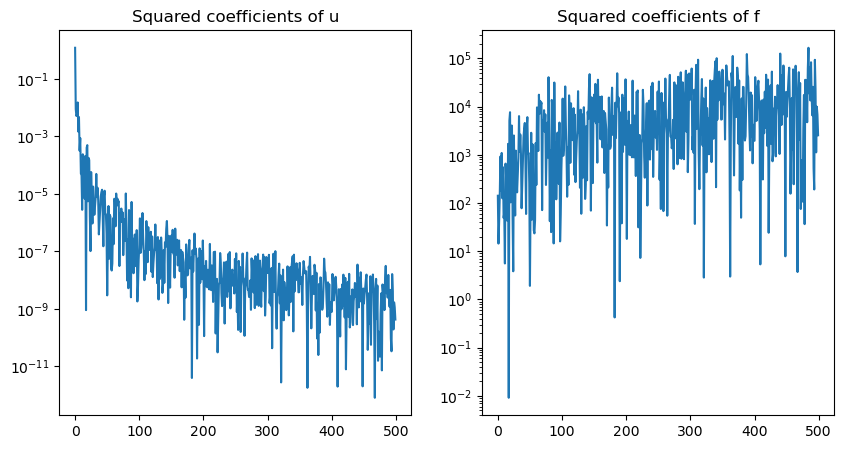

Text(0.5, 1.0, 'Function f')

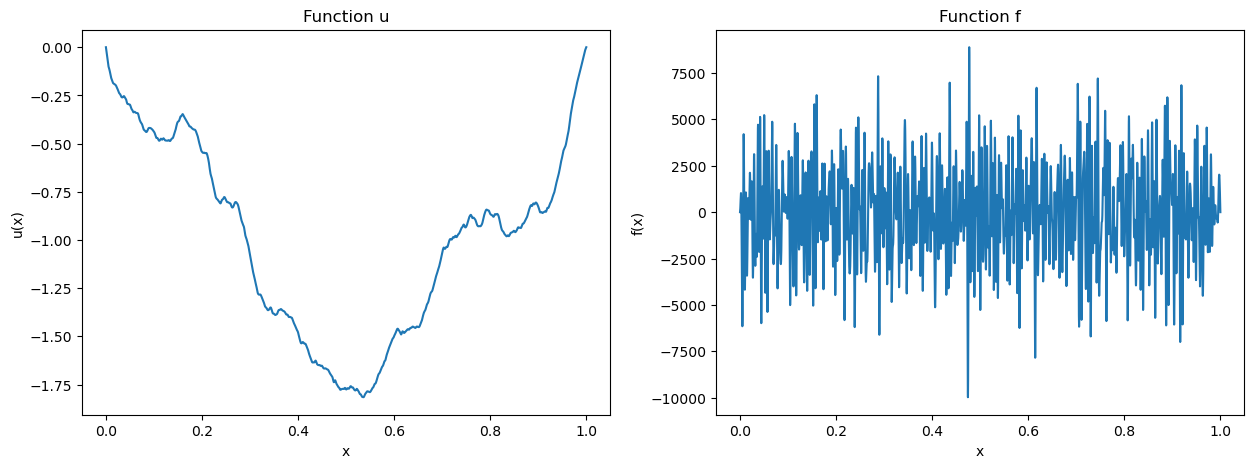

In [7]:
# Create the RHS

nu = 1.0

# draw random values for the coefficients
key = random.PRNGKey(54)

n_coef = 500

s = 1
alpha = 2*s+1 + 0.1
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f = coef_u*(nu*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2 + 1)

#x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f, L=L) #+ b(x)*u_values

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')

plt.show()

# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

## Integrate against the test function

In [8]:
# Define the support of the test function 
support = jnp.array([centers - epsilon
                     , centers + epsilon]).T

In [9]:
from scipy.special import roots_legendre
n_order = 10
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = vmap_tent_vector(root_psi, epsilon, centers)
psi_matrix = psi_matrix * w_psi


In [10]:
f_quad = evaluate_function(root_psi, coef_f, L)
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)
f_m = construct_f_meas(coef_f,psi_matrix, root_psi, L)

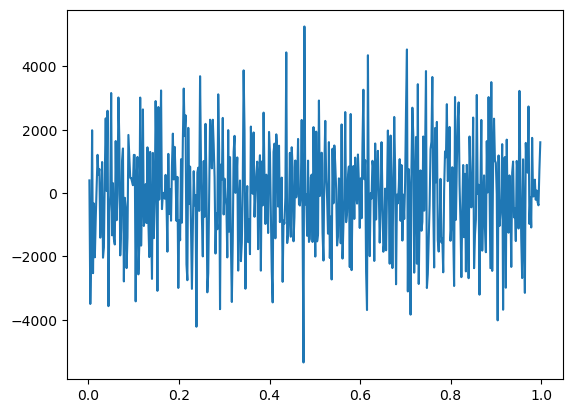

In [11]:
plt.plot(centers, f_meas)

In [12]:
# Sanity check
jnp.mean(jnp.abs(f_m - f_meas))

Array(5.83879219e-13, dtype=float64)

# Solving linear elliptic PDEs

We will solve

\begin{aligned}
\min_{\alpha} \quad & (K(\psi, \phi)\alpha - [f, \psi])\Theta^{-1} (K(\psi, \phi)\alpha - [f, \psi]) + \gamma\ \alpha^\intercal K(\phi, \phi) \alpha\\
& K(X_{\partial\Omega}, \phi)\alpha = 0
\end{aligned}
which can be transformed into
\begin{aligned}
\min_{\alpha} \quad &\alpha^\intercal \Big(K( \phi, \psi) \Theta^{-1} K(\psi, \phi)  + \gamma  K(\phi, \phi) \Big)\alpha - 2[f, \psi]\Theta^{-1}K(\psi, \phi)\alpha\\
& K(X_{\partial\Omega}, \phi)\alpha = 0
\end{aligned}

which is given by the solution of 

\begin{align}
\begin{bmatrix}
K( \phi, \psi) \Theta^{-1} K(\psi, \phi) + \gamma\ K(\phi, \phi) & K(\phi, X_{\partial\Omega})  \\
K(X_{\partial\Omega}, \phi) &  0
\end{bmatrix}
\begin{bmatrix}
    \bold{c} \\
    \boldsymbol{\nu}
\end{bmatrix}
= 
\begin{bmatrix}
    K(\phi, \psi)\Theta^{-1}[f, \boldsymbol{\psi}]  \\
    g(X_{\partial\Omega})
\end{bmatrix}
\end{align}



## Find the solutions

In [13]:
from utils_elliptic import theta_blocks
from utils_elliptic import *


length_scale = 1.0
theta_11, theta_21, theta_22 = theta_blocks(boundary,psi_matrix, root_psi, length_scale, nu)
theta_12 = theta_21.T
K = jnp.block([[theta_11, theta_12], [theta_21, theta_22]])

K_interior = jnp.vstack([theta_12, theta_22]).T
K_bc = jnp.vstack([theta_11, theta_21]).T

reg = 1e-10
bc = jnp.zeros(shape = (2, )) 

In [16]:
from utils_optim import solve_qp
c = solve_qp(K, K_interior, K_bc, stiffness_matrix, f_meas, bc, reg)

In [17]:
residual = K_interior@c -f_meas
jnp.mean(jnp.abs(residual))

Array(15.15085762, dtype=float64)

In [18]:
L_stiff = scipy.linalg.cho_factor(stiffness_matrix)
(residual)@scipy.linalg.cho_solve(L_stiff, residual)/N_tent

Array(0.20230907, dtype=float64)

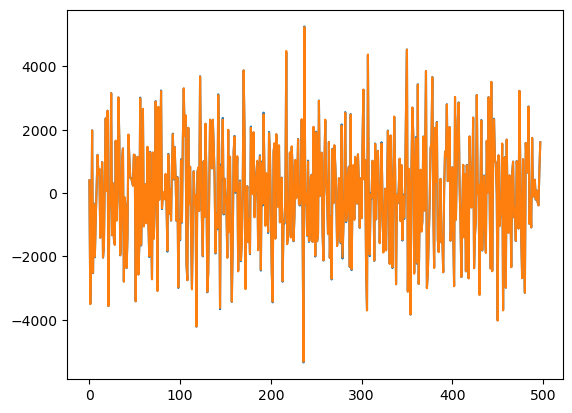

In [19]:
plt.plot(f_meas)
plt.plot(K_interior@c)

In [20]:
pred = evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary, nu)

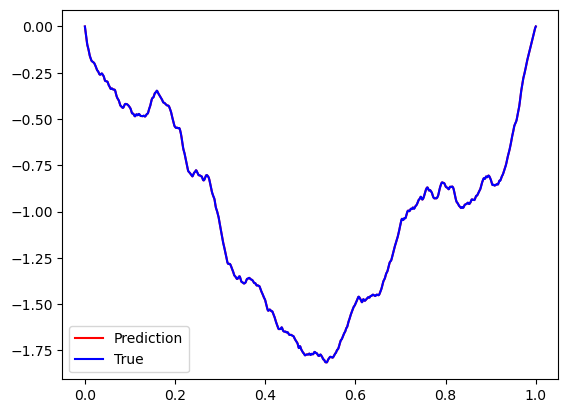

In [21]:
plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.legend()

## Evaluate the error

In [22]:
n_error = 100
x_error, w_error = roots_legendre(n_error)

x_error, w_error = root_interval(x_error, w_error, jnp.array([lower, upper]))

In [23]:
lower, upper, L

(0.0, 1.0, 1)

In [24]:
pred_error = evaluate_prediction(x_error, c, length_scale, root_psi, psi_matrix, boundary, nu)
u_error = evaluate_function(x_error, coef_u, L)

In [25]:
error = compute_error(pred_error, u_error, w_error)
error

(Array(0.00033577, dtype=float64), Array(0.00030155, dtype=float64))

# Elliptic equation with coefficients

We will solve 

$$
-\nu\Delta u + b(x)u = \xi 
$$

where $b$ will be non-constant, but smooth.

$$
\xi = \sum_{i=1}^\infty \xi_i \chi_i
$$

If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
f =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2}\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big) + b(x)\sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$


In [26]:
b = lambda x: x**2

3.1


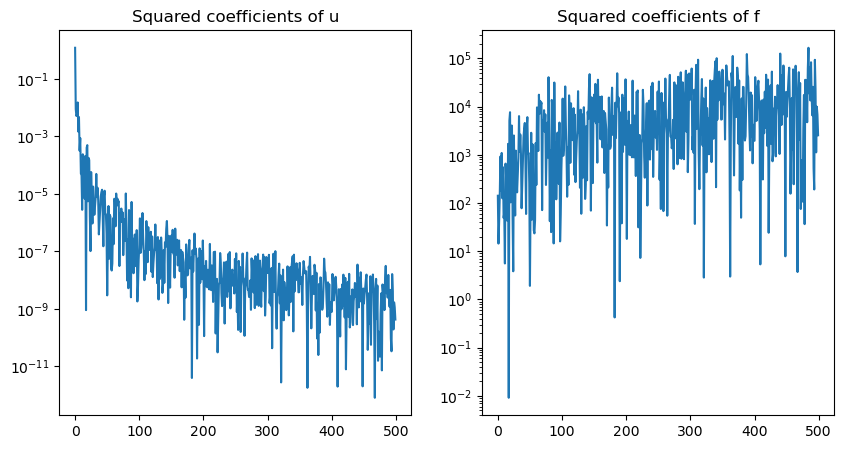

Text(0.5, 1.0, 'Function f')

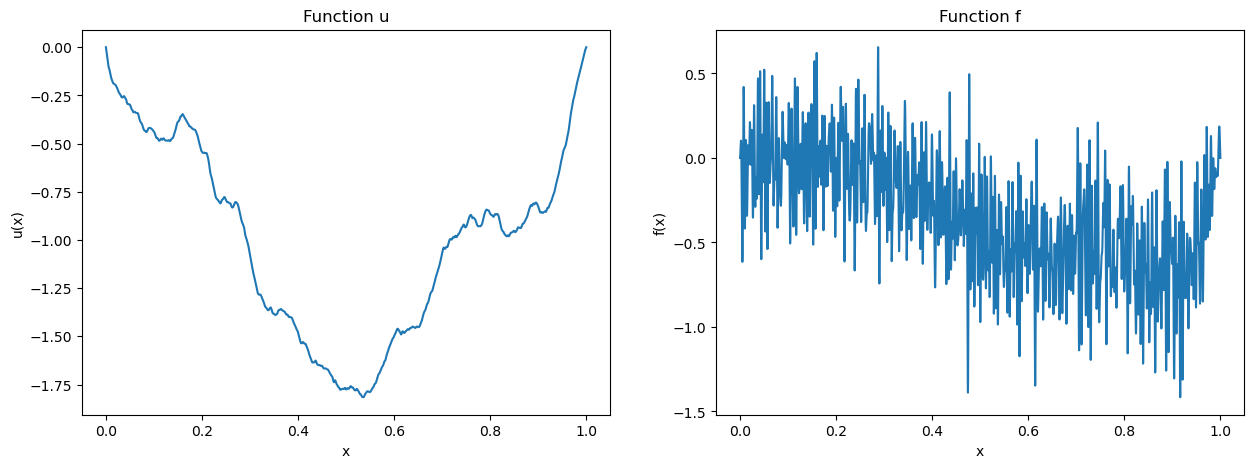

In [34]:
# Create the RHS

nu = 1e-4

# draw random values for the coefficients
key = random.PRNGKey(54)

n_coef = 500

s = 1
alpha = 2*s+1 + 0.1
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f_constant = coef_u*(nu*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2)

#x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f_constant, L=L) + b(x)*u_values

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')

plt.show()

# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

We will define $L$ to be a diff operator taking $K$ and returning 

\begin{aligned}
&L_x K(x,y) \\
&L_y L_x K(x,y)
\end{aligned}

In this case:
$$
L_x = -\nu\Delta_x + b(x)I
$$
so 
$$
L_y L_x = (-\nu\Delta_y + b(y)I)(-\nu\Delta_x + b(x)I) = \nu^2\Delta_y \Delta_x  - \varepsilon b(x)\Delta_y - \varepsilon b(y)\Delta_x + b(x)b(y)I
$$


In [36]:
def L_operator_x_b(x, y, l, epsilon):
    return epsilon*neg_laplacian_x(x, y, l) + b(x)*matern_kernel(x, y, l)

vmap_L_operator_x = jit(vmap(vmap(L_operator_x, in_axes=(0, None, None, None)), in_axes=(None, 0, None, None)))

def L_operator_y_b(x, y, l, epsilon):
    return epsilon*neg_laplacian_y(x, y, l) + b(y)*matern_kernel(x, y, l)
vmap_L_operator_y = jit(vmap(vmap(L_operator_y, in_axes=(None, 0, None, None)), in_axes=(0, None, None, None)))


# def LL_operator(x, y, l, epsilon):
#     return -epsilon**2*double_neg_laplacian(x, y, l) + 2*epsilon*neg_laplacian_x(x, y, l)+ matern_kernel(x, y, l)

def LL_operator(x, y, l, epsilon):
    return epsilon**2*double_neg_laplacian(x, y, l) + epsilon*b(y)*neg_laplacian_x(x, y, l) + epsilon*b(x)*neg_laplacian_y(x, y, l)+ b(x)*b(y)*matern_kernel(x, y, l)

vmap_LL_operator = vmap(vmap(LL_operator, in_axes=(0, None, None, None)), in_axes = (None, 0, None, None))

# Defining how to compute the integrals against test functions
def bilinear_form_K(x, y, points_1, points_2, length_scale, epsilon):
    # Create the kernel matrix 
    K = vmap_LL_operator(points_1, points_2, length_scale, epsilon)
    return jnp.dot(x, K @ y)

vmap_bilinear_form_K = jit(vmap(vmap(bilinear_form_K,  in_axes=(None, 0, None, 0, None, None)), in_axes=(0, None, 0, None, None, None)))

def linear_form_K(x, p, points, length_scale, epsilon):
    # Create the kernel matrix 
    K = vmap_L_operator_y(p, points, length_scale, epsilon)
    return K@x

vmap_linear_form_K = jit(vmap(vmap(linear_form_K, in_axes=(None, 0, None, None, None)), in_axes=(0, None, 0, None, None)))


# Define a function that constructs the various blocks of the matrix
@jit
def theta_blocks(boundary,psi_matrix, root_psi, length_scale, epsilon):
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_21 = jnp.squeeze(vmap_linear_form_K(psi_matrix, boundary, root_psi, length_scale, epsilon), axis = -1)
    theta_22 = vmap_bilinear_form_K(psi_matrix, psi_matrix, root_psi, root_psi, length_scale, epsilon)
    return theta_11, theta_21, theta_22

@jit
def evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary, epsilon):
    K_boundary = vmap_kernel(x,boundary, length_scale)
    K_interior = jnp.squeeze(vmap_linear_form_K(psi_matrix, x[:, None], root_psi, length_scale, epsilon), axis = -1).T
    K_evaluate = jnp.block([[K_boundary, K_interior]])

    return K_evaluate@c
